In [1]:
# Marc Garard
# 11/25/2018
# this work is inspired by the paper SELECTING THE NUMBER OBINS IN A HISTOGRAM:a DECISION THEORETIC APPROACH
# by Kun He and Glen Meedan, Journal of Statistical Planning an Inference, Vol 61 (1997), (59)
# In the paper they explore the idea of using the loss function
# Here I set up 4 distributions samples ( normal, gama, exponetial, uniform ) and test the number of bins againt the
# mean root error relative to the ideal distritbution to determine the optimal number of bins that should be used.
# Noted is that the multiple runs generate a distribution of the ideal number of bins themselves and He & Meedan used 
# a Guassian distribution.
# The question that then comes to mind is if the ideal bin size should be used or the best fit bin size should be used.....
# That's for the observer to decide.
# Inherently, the idea is flawed if applied to all cases.  
    # A. The uniform distribution, for example comes out to 1 bin. One bin does not show the variability of the data 
    # in the distribution.
    # B. The gamma function often arives at 2 bins for the best fit and again does not display the fine scale variability
    # of the data.
    # The idea presented in paper may arguably be the best only for Guassian and exponential curves based on this test of the 
    # idea.  However, a very important question arise of the benefit of observing the granularity of data and how even unintended
    # consequences arise through generalizations such as a concept of "optimization".  What is lost in optimization should also
    # be retained and reinforces the need for inclusion of the mean squared error bars (yerr)
    # Plotting of the mean squared error to the bin size demonstrates rule of thumb 5-20 bins being appropriate for most
    # histograms.
    # C. The MSE vs. Bins plost shows that 10 bins seem to represent the Normal or Exponetial functions and 15-20 bins 
    # seem to be a good representation for Gamma functions
    # D. Uniform plots remain a special case to be dealt with independently
# Conclusion: the absence of error bars for histogram plots is an issue of lost data for many.  In the example here,
# the histogram was replaced with the bar chart where the width is set to the increment size.  The margin of error bars
# reveal some real outliers. While the outliers may not have meaning in a random selection for a computer, it may have
# consequence in the real world decision making; though, increasing random distribution sample sizes do decrease 
# the yerr bar ranges.

# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.mlab as mlab
import math
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error
%matplotlib notebook

# generate 4 random variables from the random, gamma, exponential, and uniform distributions
size = 10000
x1 = np.random.normal(0, 1, size)
x2 = np.random.gamma(2, 1.5, size)
x3 = np.random.exponential(2, size)
x4 = np.random.uniform(0,6, size)

# set up control variables
data = [x1, x2, x3, x4]

# controls for the different curves
# norm stats.norm.pdf(xl1, mu, sigma)
xl1 = np.linspace(0 - 3*math.sqrt(1), 0 + 3*math.sqrt(1), 10000)
def normFunc( x ): return stats.norm.pdf( x, 0, math.sqrt(1) )
# gamma  stats.gamma.pdf(xl2,2, scale = 1.5)
xl2 = np.linspace (0, 18, 10000)
def gammaFunc( x ): return stats.gamma.pdf( x, 2, scale = 1.5 ) 
# exponential
xl3 = np.linspace(0, 16, 10000)
def expFunc( x ): return stats.expon.pdf(x, 0, 2)
# uniform
xl4 = np.linspace(0, 6, 10000)
def uniformFunc( x ): return 1/6


# table the functions
functions ={ '0':  normFunc, '1' : gammaFunc, '2' : expFunc, '3': uniformFunc }
data = [x1, x2, x3, x4]

# this function takes a data list with bin size arguments and returns a list of steps values
def getSteps( dataList, binSize ):
    stepsize = ( max(dataList) - min(dataList) ) / binSize
    steps = [ ( min(dataList) + stepsize / 2 )+ (j) * stepsize for j in range(binSize) ]
    return steps

# this function takes a list of distributions sets, a list of distribution functions, and a low and high limits for the number
# of bins to consider.  After testing the range of bins against the data, it returns the bin number with the lowest mse, the 
# higest mse, binSizeList and a set of the calculated mse.
def findOptimalBins( dataList, functionList, lowRange = 1, highRange = 100 ):
    binSizeList = [[] for i in range( len( dataList ) )]
    mseList = [[] for i in range( len( dataList ) )] # empty list of lists to store the mse data to return
    best, worst = None, None
    bestBinNum, worstBinNum = [0]*len(data), [0]*len(data)  # holds best and worst bin number for data set
    if lowRange <= 0: lowRange = 1 # ensures valid range
    if highRange < lowRange: highRange = lowRange + 1
    dataLen = len(dataList[0])
    # looop through the data sets
    for i in range(len(dataList)):
        # loop through the bins sizes
        for binSize in range( lowRange,highRange+1 ):
            # check for bin sizes that can break the data evenly
            if len(dataList[i])%binSize == 0:
                binSizeList[i].append(binSize)
                # get the step sizes and number x-values of the steps.  Calcluate the means of the ideal mean and the bargraph
                # means ( imean, barmeans ).  Determine the mean square error between the two.
                steps = getSteps( dataList[i], binSize )
                imeans = [ functionList[str(i)](k) for k in steps ]
                barmeans = np.histogram( dataList[i][:dataLen], bins = binSize, density = True ) [0]
                mse = mean_squared_error( imeans, barmeans )
                # conserve the mse per bin
                mseList[i].append(mse)
                # compare and save the best scoring number of bins.
                if (best is None) or (mse < best):
                    best = mse
                    bestBinNum[i] = binSize
                if (worst is None) or (mse > worst):
                    worst = mse
                    worstBinNum[i] = binSize
            # resest the results bin variables
            if binSize == highRange: best, worst = None, None
    return bestBinNum, worstBinNum, binSizeList, mseList

bestBinNum, worstBinNum, binSizeList, mseList = findOptimalBins( data, functions, lowRange = 3, highRange = 50 )


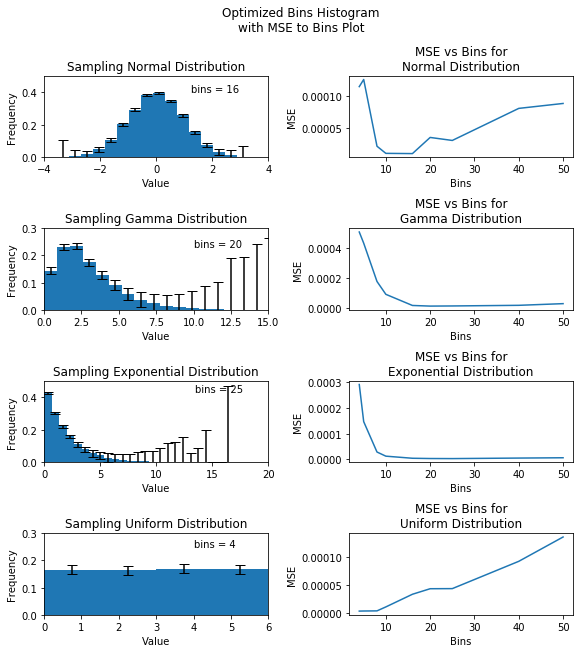

In [2]:
# set up subplots and table data
# set up and show histogram
curveType = ['Normal', 'Gamma', 'Exponential', 'Uniform']
annotation = [ [1.25,0.4], [10, 0.23], [13.5, 0.43], [4, 0.25] ]
axisList = [[-4,4,0,0.5], [0,15,0,0.3], [0,20,0,0.5], [0,6,0,0.3]]

fig2, ( (ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42) ) = plt.subplots(4,2, figsize=(10, 10))
fig2.tight_layout(pad=8, w_pad=5, h_pad=5)
#fig2.subplots_adjust(left=4, bottom=4, right=5, top=5, wspace=5, hspace=5)
fig2.suptitle('Optimized Bins Histogram\nwith MSE to Bins Plot')
axs = [ [ax11, ax21, ax31, ax41], [ax12, ax22, ax32, ax42] ]
# set up and show histogram
annotation = [ [1.25,0.4], [10, 0.23], [13.5, 0.43], [4, 0.25] ]
axisList = [[-4,4,0,0.5], [0,15,0,0.3], [0,20,0,0.5], [0,6,0,0.3]]

# Chart the histograms / barchart with the MSE vs. Bins plot
for i in range( len( axs[0] ) ):
    steps = getSteps( data[i], bestBinNum[i] )
    barmeans = np.histogram( data[i][:len(data[i])], bins = bestBinNum[i], density = True ) [0]
    # display the optimized histogram for range
    axs[0][i].cla()
    #axs[0][i].hist(data[i][:(10000)], density = True, bins = bestBinNum[i] )
    # calculate the MSE (SEM)
    df = pd.DataFrame( data = { 'data' : data[i] } )
    df_sem = df.groupby(pd.cut(df['data'], bestBinNum[i]), axis = 0).sem()
    df_sem.fillna( 0, inplace = True )
    df_h = df_sem * stats.t.ppf((1-0.95) / 2, len(df)-1)
    axs[0][i].bar( steps, barmeans, width = ( steps[1]-steps[0] ), yerr = df_h.values, capsize = 5 )
    axs[0][i].set_title('Sampling {} Distribution'.format(curveType[i]))
    axs[0][i].set_ylabel('Frequency')
    axs[0][i].set_xlabel('Value')
    axs[0][i].axis( axisList[i] )
    axs[0][i].annotate('bins = {}'.format( bestBinNum[i]), annotation[i] )
    # display plot of mse for bin sizes 
    axs[1][i].cla()
    axs[1][i].plot( binSizeList[i], mseList[i] )
    axs[1][i].set_title('MSE vs Bins for\n{} Distribution'.format(curveType[i]))
    axs[1][i].set_ylabel('MSE')
    axs[1][i].set_xlabel('Bins')
    #axs[1][i].axis( axisList[i] )